<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/GD/%5BGD_1%5DSentencePiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 프로젝트 : SentencePiece 사용하기


### NAVER_REVIEW DATA LOAD

    id: The review id, provieded by Naver
    document: The actual review
    label: The sentiment class of the review. (0: negative, 1: positive)

In [1]:
#Colab에서 Mecab 설치
%%capture
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# !wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# !mkdir -p /content/drive/MyDrive/Aiffel/data/sp_tokenizer/data
# !mv korean-english-park.train.tar.gz /content/drive/MyDrive/Aiffel/data/sp_tokenizer/data
# !cd /content/drive/MyDrive/Aiffel/data/sp_tokenizer/data
# !tar -xzvf korean-english-park.train.tar.gz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
from konlpy.tag import Mecab

!pip install sentencepiece
import sentencepiece as spm
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf.__version__)
print(np.__version__)
# print(konlpy.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.8.2
1.21.6


### 데이터 로드/ 분석

In [4]:
data_file = '/content/drive/MyDrive/Aiffel/data/sp_tokenizer/nsmc/ratings.txt'

data = pd.read_table(data_file)
data

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [5]:
data.label.unique()

array([1, 0])

In [6]:
data.document.isnull().sum() # 결측 데이터 확인 None은 isnull로 카운팅 되지않음
data = data.dropna()
len(data)

199992

In [7]:
data['document'].duplicated().sum()

5449

In [8]:
length_list = []
for i in range(len(data.document)):
  
  try:
    sen_length = len(data.document[i]) 
    length_list.append(sen_length)
  except: print(i)

length_list[:10]

46471
60735
77665
84098
127017
172375
173526
197279


[19, 137, 36, 54, 27, 29, 16, 27, 1, 14]

In [9]:
len(data.document.iloc[55737])

45

In [10]:
len(list(set(data.document)))

194543

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


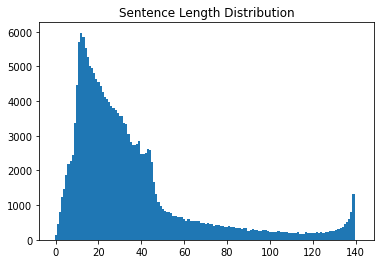

In [11]:
min_len = 999
max_len = 0
sum_len = 0
cleaned = data.drop_duplicates(['document'])
for s in cleaned.document:
  length = len(s)
  if min_len > length: min_len = length
  if max_len < length: max_len = length
  sum_len += length

print("문장의 최단 길이:",min_len)
print("문장의 최장 길이:",max_len)
print("문장의 평균 길이:",sum_len//len(cleaned.document))

sentence_length = np.zeros((max_len), dtype=np.int)

for s in cleaned.document:
  sentence_length[len(s)-1] += 1

plt.bar(range(max_len),sentence_length,width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [12]:
def check_sentence_with_length(raw,length):    
  cnt = 0

  for s in raw:
    if len(s) == length:
      print(s)
      cnt += 1
      if cnt > 10: return

check_sentence_with_length(cleaned.document,10)

내용이너무좋아요.ㅎ
뀰잼이다뀰잼이라구여
13살이엇냐?...
알파치노 연기때문에
이물감. 시 같았다
매력적인 영화...
이거 재밌는데...
.겁쟁이페달보고싶다
한국 영화치고 좋다
정말 멋진 결말!ㅎ
너무 잘 봣어요..


In [13]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if idx <= 10:
        print(f"{idx+1} 문장길이:", _sum)

1 문장길이: 124
2 문장길이: 460
3 문장길이: 793
4 문장길이: 1222
5 문장길이: 1469
6 문장길이: 1882
7 문장길이: 2187
8 문장길이: 2270
9 문장길이: 2440
10 문장길이: 3379
11 문장길이: 4459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


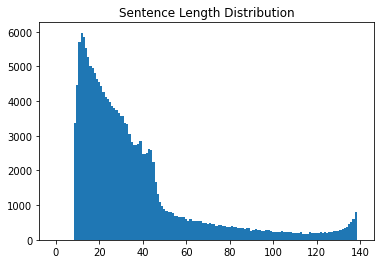

In [14]:
max_len = 140 # 미니배치 문장 길이를 맞추기 위해 Padding 처리
min_len = 10 # 너무 짧은 데이터는 noise 가능성 있음.

filtered_corpus = cleaned[(cleaned['document'].str.len() < max_len) & (cleaned['document'].str.len() >= min_len)]
sentence_length = np.zeros((max_len),dtype=np.int)

for s in filtered_corpus.document:
  sentence_length[len(s)-1] += 1

plt.bar(range(max_len),sentence_length,width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### SentencePiece 구성

In [15]:
temp_file = '/content/drive/MyDrive/Aiffel/data/sp_tokenizer/data/practice.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus.document:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

# vocab size=8000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

# vocab size=8000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={} --bos_id=1 --eos_id=2 --unk_id=0'.format(temp_file, vocab_size)    
)

# vocab size = 16000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={} --bos_id=1 --eos_id=2 --unk_id=0'.format(temp_file, vocab_size*2)    
)
# vocab size=8000, model_type=char
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_char_8k --model_type=char --vocab_size={} --bos_id=1 --eos_id=2 --unk_id=0'.format(temp_file, vocab_size)    
)
# vocab size=8000, model_type=word
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_word_8k --model_type=word --vocab_size={} --bos_id=1 --eos_id=2 --unk_id=0'.format(temp_file, vocab_size)    
)


In [16]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_bpe_16k*
!ls -l kor_spm_char_8k*
!ls -l kor_spm_word_8k*

-rw-r--r-- 1 root root 4097368 Jul 11 11:51 kor_spm_unigram_8k_best_model_lstm.h5
-rw-r--r-- 1 root root  374904 Jul 11 14:04 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root  144373 Jul 11 14:04 kor_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 4097368 Jul 11 11:54 kor_spm_bpe_8k_best_model_lstm.h5
-rw-r--r-- 1 root root  370381 Jul 11 14:04 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root  115574 Jul 11 14:04 kor_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 4097368 Jul 11 11:57 kor_spm_bpe_16k_best_model_lstm.h5
-rw-r--r-- 1 root root  523576 Jul 11 14:05 kor_spm_bpe_16k.model
-rw-r--r-- 1 root root  258765 Jul 11 14:05 kor_spm_bpe_16k.vocab
-rw-r--r-- 1 root root 4097368 Jul 11 12:03 kor_spm_char_8k_best_model_lstm.h5
-rw-r--r-- 1 root root  258103 Jul 11 14:05 kor_spm_char_8k.model
-rw-r--r-- 1 root root   21952 Jul 11 14:05 kor_spm_char_8k.vocab
-rw-r--r-- 1 root root 4097368 Jul 11 12:07 kor_spm_word_8k_best_model_lstm.h5
-rw-r--r-- 1 root root  406238 Jul 11 14:05 kor_spm_word_8k.model
-rw-r

In [17]:
vocab_file = '/content/kor_spm_bpe_8k.vocab'
# vocab_list = pd.read_csv(vocab_file, sep='\t')
vocab_list = pd.read_csv(vocab_file, sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [18]:
def sentence_print(model):
#sentencePiece 확인
  s = spm.SentencePieceProcessor()
  s.Load(f'{model}.model')

  # SentencePiece를 활용한 sentence -> encoding
  tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
  print(tokensIDs)

  # SentencePiece를 활용한 sentence -> encoded pieces
  print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

  # SentencePiece를 활용한 encoding -> sentence 복원
  print(s.DecodeIds(tokensIDs))

In [19]:
sentence_print('kor_spm_unigram_8k')

[1391, 9, 384, 15, 1331, 9, 148, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [20]:
sentence_print('kor_spm_bpe_8k')

[4940, 862, 6552, 6299, 1405, 6295, 6396, 6289, 6287]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [21]:
sentence_print('kor_spm_bpe_16k')

[7631, 11655, 1405, 14295, 13650, 14287]
['▁아버지가', '방에', '들어', '가', '신다', '.']
아버지가방에들어가신다.


In [22]:
sentence_print('kor_spm_char_8k')# 제외

[3, 15, 189, 9, 12, 269, 16, 35, 22, 12, 113, 6, 4]
[]
아버지가방에들어가신다.


In [23]:
sentence_print('kor_spm_word_8k') # 제외

[0]
[]
 ⁇ 


In [24]:
def sp_tokenize(corpus,sp):
    s = spm.SentencePieceProcessor()
    s.Load(f'{sp}.model')
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(f"{sp}.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=max_len)

    return tensor, word_index, index_word

### LSTM 모델 훈련

In [30]:
def sentence_lstm(sp,vocab_size=8000,word_vector_dim=32):

  tensor, word_index, index_word = sp_tokenize(filtered_corpus['document'],sp)

  #data split
  filtered_label = np.array(filtered_corpus['label'])
  x_train, x_test, y_train, y_test = train_test_split(tensor, filtered_label, test_size=0.2)

  vocab_size = vocab_size    # 어휘 사전의 크기입니다(10,000개의 단어)
  word_vector_dim = word_vector_dim  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

  #model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim))
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.summary()
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  check = ModelCheckpoint(f'{sp}_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)
  epochs=20
  batch_size=64

  lstm_history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[early,check],
                    verbose=1
                    )
  
  loaded_model = load_model(f'{i}_best_model_lstm.h5')
  print(f"\n {i} 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))
  test_loss.append(loaded_model.evaluate(x_test, y_test)[0])
  test_acc.append(loaded_model.evaluate(x_test, y_test)[1])

  visualize_train(lstm_history, param = f'{sp}')

In [31]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          256000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1803/1804 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8160
Epoch 1: saving model to kor_spm_unigram_8k_best_model_lstm.h5
1804/1804 [==============================] - 23s 12ms/step - loss: 0.4018 - accuracy: 0.8160 - val_loss: 0.3493 - val_accuracy: 0.8457
Epoch 2/20
1802/

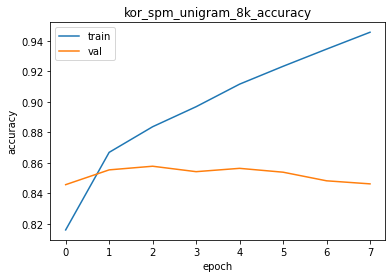

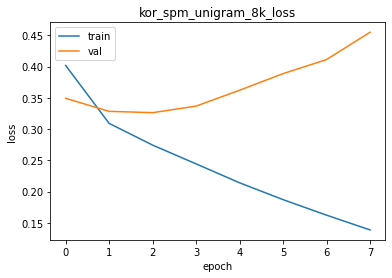

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          256000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               82432     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1800/1804 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8180
Epoch 1: saving model to kor_spm_bpe_8k_best_model_lstm.h5
1804/1804 [==============================] - 23s 12ms/step - loss: 0.3960 - accuracy: 0.8181 - val_loss: 0.3403 - val_accuracy: 0.8519
Epoch 2/20
1802/1804

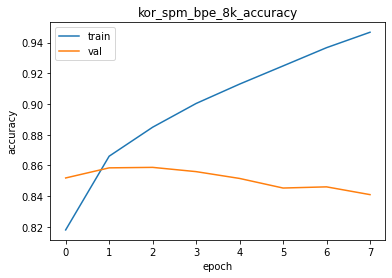

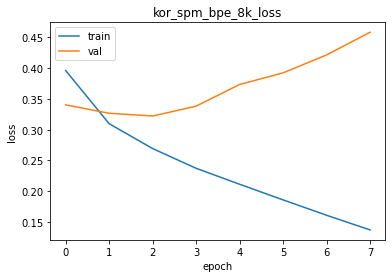

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          256000    
                                                                 
 lstm_3 (LSTM)               (None, 128)               82432     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1801/1804 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8056
Epoch 1: saving model to kor_spm_bpe_16k_best_model_lstm.h5
1804/1804 [==============================] - 24s 12ms/step - loss: 0.4152 - accuracy: 0.8056 - val_loss: 0.3672 - val_accuracy: 0.8315
Epoch 2/20
1801/180

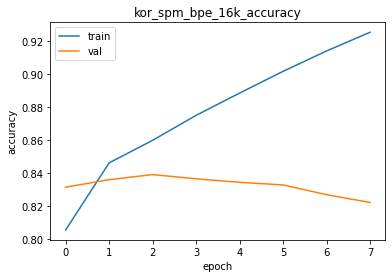

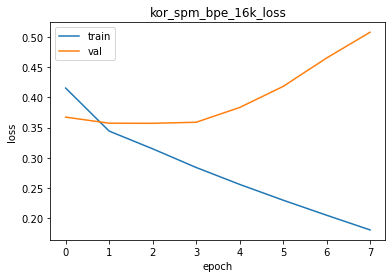

In [32]:
'''
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_unigram_16k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_char_8k*
!ls -l kor_spm_word_8k*
'''
#predict test
test_loss = []
test_acc = []

option_list = ['kor_spm_unigram_8k','kor_spm_bpe_8k','kor_spm_bpe_16k']
for i in option_list:
  sentence_lstm(i)
  print('===============================================================================================')
  

In [33]:
test_loss,test_acc

([0.4539063572883606, 0.465746134519577, 0.5088862776756287],
 [0.8433775305747986, 0.8419082760810852, 0.8198148012161255])

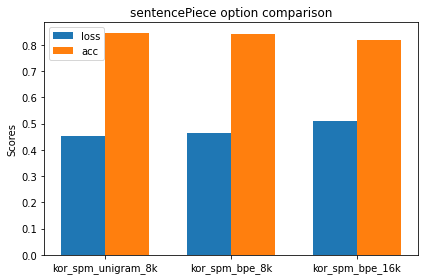

In [34]:
#sentencepiece 옵션별 loss,accuracy
labels = option_list

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_loss, width, label='loss')
rects2 = ax.bar(x + width/2, test_acc, width, label='acc')

ax.set_ylabel('Scores')
ax.set_title('sentencePiece option comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Mecab

In [42]:
# # 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# # Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
mecab = Mecab()
def mecab_split(sentence):
  return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus.document:
  mecab_corpus.append(mecab_split(kor))

In [36]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [37]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 59284


In [38]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

인도 영화 는 역시 ! !! 스토리 , 영상 , 배우 들 의 연기 까지 뭐 하나 빠지 는 거 없이 꽉 찬 영화 ! ! 대박 감동 ~ ㅠㅠ


In [39]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

인도 영화 는 역시 ! !! 스토리 , 영상 , 배우 들 의 연기 까지 뭐 하나 빠지 는 거 없이 꽉 찬 영화 ! ! 대박 감동 ~ ㅠㅠ 


In [40]:
#data split
filtered_label = np.array(filtered_corpus['label'])
x_train, x_test, y_train, y_test = train_test_split(mecab_tensor, filtered_label, test_size=0.2)

vocab_size = 50000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

#model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('mecab_best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)
epochs=20
batch_size=64

lstm_history = model.fit(x_train,
                  y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[early,check],
                  verbose=1
                  )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         6400000   
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,531,713
Trainable params: 6,531,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1804/1804 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4995
Epoch 1: saving model to mecab_best_model_lstm.h5
1804/1804 [==============================] - 26s 14ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 2/20
1801/1804 [===

## 회고록
### sentencePiece
실험 당시 모종의 이유에 의해서(?)  acc가 50%정도밖에 나오지 않는 현상을 보였다. 지금까지의 수정결과 인스턴스로 받아왔던 변수 s = spm.SentencePieceProcessor()에서 다른 옵션을 실험할때 가장 처음에 Load했던 unigram_8k.model을 계속 사용해서 훈련을 진행한 것처럼 보였다. (실제 훈련상에서 unigram_8k를 제외한 나머지 모델들이 모두 성능이 좋지 못했다.) 이를 하나의 함수에 같이 넣어서 진행하니 완화된 모습을 보였다.  
최종 결과는 다음과 같다. 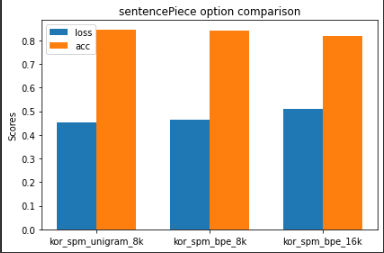

### Mecab
앞의 sentencepiece의 오류 잡는 시간을 너무 많이 할애해서 많은 부분을 연습해보지 못해 아쉬웠다. 기본적으로 좋은 성능을 보이는 것으로 알고있는데, 어떤 부분을 빼먹은 것인지 성능이 온전치 못했다.